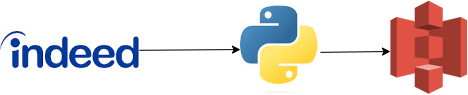

## Extraction:
The code extracts job data from the Indeed website by using Selenium to scrape job links and details. It retrieves job titles, descriptions, locations, salaries, and other relevant information.

## Transformation:
The extracted job data is transformed using pandas, a powerful data manipulation library. The job data is structured into a pandas DataFrame, allowing for further analysis and processing. Additional transformations can be applied based on specific requirements.

## Load:
The transformed job data is saved to a CSV file using the save_job_data_to_csv function. The CSV file contains the structured job data in a tabular format, making it easy to store and share.

## Additional Operations:
The code includes functionality to upload the CSV file to an Amazon S3 bucket using the upload_to_s3 function. This allows for cloud storage and accessibility of the job data.

Please note that the provided code snippet does not include the complete ETL process, such as scheduling the extraction and loading process. You can build upon this code to automate the ETL process using tools like AWS Lambda or Apache Airflow.

#### For a more detailed guide on how to use Apache Airflow for ETL processes, you can refer to this video: https://youtu.be/q8q3OFFfY6c

In [16]:
import csv
import time
import pandas as pd
from selenium import webdriver
from selenium.common.exceptions import WebDriverException
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import logging
import boto3
from botocore.exceptions import NoCredentialsError

In [17]:
logging.basicConfig(filename='job_scraper.log', level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')

def setup_webdriver():
    try:
        driver = webdriver.Chrome()
        return driver
    except WebDriverException as e:
        logging.error(f'Error occurred while setting up WebDriver: {e}')
        return None

In [18]:
def scrape_job_links(driver, url):
    try:
        driver.get(url)
        time.sleep(2)  # Sleep for a few seconds to allow the page to load

        count = driver.find_elements("css selector", "div.jobsearch-JobCountAndSortPane-jobCount.css-1af0d6o.eu4oa1w0")
        job_count_text = count[0].text.strip()
        job_count = int(job_count_text.split()[0])
        print("Job Count:", job_count)

        href_values = []

        while len(href_values) < job_count:
            a_elements = driver.find_elements("css selector", "a.jcs-JobTitle.css-jspxzf.eu4oa1w0")
            for element in a_elements:
                href_value = element.get_attribute("href")
                href_values.append(href_value)

            if len(href_values) >= job_count:
                break

            driver.get(url)
            time.sleep(2)  # Sleep for a few seconds to allow the page to load

        return href_values
    except Exception as e:
        logging.error(f'Error occurred while scraping job links: {e}')
        return []

In [19]:
def fetch_job_details(driver, url):
    try:
        driver.get(url)
        time.sleep(2)  # Sleep for a few seconds to allow the page to load

        page_source = driver.page_source
        soup = BeautifulSoup(page_source, 'html.parser')

        title = soup.find("h1", class_="icl-u-xs-mb--xs icl-u-xs-mt--none jobsearch-JobInfoHeader-title")
        job_title = title.text.strip() if title else None

        description = soup.find("div", class_="jobsearch-jobDescriptionText")
        job_description = description.text.strip() if description else None

        company_location = soup.find(attrs={"data-testid": "inlineHeader-companyLocation"})
        company_location = company_location.text.strip() if company_location else None

        salary_info_and_job_type = soup.find("div", {"id":"salaryInfoAndJobType"})
        salary_info_and_job_type = salary_info_and_job_type.text.strip() if salary_info_and_job_type else None

        current_date = datetime.now().date()
        previous_date = current_date - timedelta(days=1)

        return {'Job Title': job_title, 'Posted Date': previous_date, 'Salary and Job Type': salary_info_and_job_type, 'Location': company_location, 'Job Description': job_description,'url':url}
    except Exception as e:
        logging.error(f'Error occurred while fetching job details for URL: {url}\nError: {e}')
        return {}

In [20]:
def scrape_job_data(url):
    driver = setup_webdriver()
    if driver is None:
        return None

    href_values = scrape_job_links(driver, url)
    if not href_values:
        return None

    job_data = []
    for url in href_values:
        job_details = fetch_job_details(driver, url)
        if job_details:
            job_data.append(job_details)

    driver.quit()

    return pd.DataFrame(job_data)

def save_job_data_to_csv(df, file_name):
    try:
        df.to_csv(file_name, index=False)
        print(f"Job data exported to {file_name}")
        return True
    except Exception as e:
        logging.error(f'Error occurred while saving job data to CSV: {e}')
        return False

In [21]:
def upload_to_s3(file_path, bucket, object_name):
    session = boto3.Session(
        aws_access_key_id=aws_access_key_id,
        aws_secret_access_key=aws_secret_access_key
    )
    s3 = session.client('s3')
    

    try:
        s3.upload_file(file_path, bucket, object_name)
        print(f"File uploaded to S3 bucket: {bucket}/{object_name}")
        return True
    except NoCredentialsError:
        logging.error("AWS credentials not found.")
        return False
    except Exception as e:
        logging.error(f"Error occurred while uploading file to S3: {e}")
        return False

### Please note that the options represent the age of the data, indicating the time period for which you want to retrieve the data. 
#### fromage=1
1. No. 1 use for 24hr old data
2. No. 7 use for Last 3 days
3. No. 7 use for Last 7 days
4. No. 14 use for Last 14 days
5. keyword 'last' use for Since for your last visit

In [23]:
# Set up configuration
q = "cyber+security"
l = "Toronto%2C+ON"
limit = 50
start = 0
formage=1

url = f"https://ca.indeed.com/jobs?q={q}&l={l}&limit={limit}&fromage={formage}"

#put your aws_access_key_id and aws_secret_access_key
aws_access_key_id = ''
aws_secret_access_key = ''

# Scrape job data
df = scrape_job_data(url)

# Save job data to CSV
if df is not None:
    current_date = datetime.now().date()
    previous_date = current_date - timedelta(days=1)
    file_name = f"job_listings_{previous_date}.csv"
    save_success = save_job_data_to_csv(df, file_name)
    if save_success:
        # Set your S3 bucket details
        s3_bucket = 'indeed-data-etl-pipeline'
        s3_file_name = f"job_listings/{file_name}"  # Assuming a "job_listings" folder in the bucket

        # Upload the CSV file to S3
        upload_success = upload_to_s3(file_name, s3_bucket, s3_file_name)
        if upload_success:
            print(f"Job data uploaded to S3: {s3_bucket}/{s3_file_name}")
else:
    logging.error("No job data to save.")

Job Count: 9
Job data exported to job_listings_2023-07-09.csv
File uploaded to S3 bucket: indeed-data-etl-pipeline/job_listings/job_listings_2023-07-09.csv
Job data uploaded to S3: indeed-data-etl-pipeline/job_listings/job_listings_2023-07-09.csv
